In [1]:
import matplotlib.pyplot as plt
import bootstrap
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
import tf_utils as tfu
import time
import os
import wandb

In [2]:
from common.data import find_dbs, DnaSequenceGenerator, DnaLabelType
from common.models import dnabert
from common.utils import subbatch_train_step

In [3]:
strategy = tfu.strategy.gpu(0)

2022-07-03 08:13:51.409639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 08:13:51.409963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 08:13:51.417105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 08:13:51.417326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-03 08:13:51.417498: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [4]:
api = wandb.Api()

dataset_path = api.artifact("nachusa-dna/dnasamples:latest").download()
dataset_path

samples = find_dbs(os.path.join(dataset_path, "train"))
len(samples)

def create_model(seed=0):
    keras.utils.set_random_seed(seed)
    dataset = DnaSequenceGenerator(
        samples=samples,
        sequence_length=150,
        batch_size=512,
        kmer=3,
        labels=DnaLabelType.KMer,
        rng=np.random.default_rng(seed)
    )
    
    base = dnabert.DnaBertModel(
        length=150,
        kmer=3,
        embed_dim=8,
        stack=8,
        num_heads=12,
        pre_layernorm=True)

    pretrain = dnabert.DnaBertPretrainModel(base)
    pretrain.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(1e-4),
        metrics=keras.metrics.SparseCategoricalAccuracy()
    )
    return dataset, pretrain

wandb: Downloading large artifact dnasamples:latest, 12237.27MB. 1260 files... Done. 0:0:0.1


In [19]:
dataset, pretrain = create_model(0)
pretrain.subbatching = False
pretrain.fit(dataset)

128/128 [==============================] - 44s 312ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.0190


In [5]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset)

2022-07-03 08:13:54.301412: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


128/128 [==============================] - 49s 317ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.0190


In [6]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset, subbatch_size=512)

128/128 [==============================] - 50s 317ms/step - loss: 0.7156 - sparse_categorical_accuracy: 0.0190


In [7]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset, subbatch_size=256)

128/128 [==============================] - 51s 326ms/step - loss: 0.7157 - sparse_categorical_accuracy: 0.0191


In [8]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset, subbatch_size=128)

128/128 [==============================] - 53s 343ms/step - loss: 0.7159 - sparse_categorical_accuracy: 0.0193


In [9]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset, subbatch_size=64)

128/128 [==============================] - 57s 379ms/step - loss: 0.7161 - sparse_categorical_accuracy: 0.0191


In [10]:
dataset, pretrain = create_model(0)
pretrain.subbatching = True
pretrain.fit(dataset, subbatch_size=32)

128/128 [==============================] - 68s 463ms/step - loss: 0.7158 - sparse_categorical_accuracy: 0.0196


In [11]:
x = [32, 64, 128, 256, 512]
y = [463, 379, 343, 326, 317]

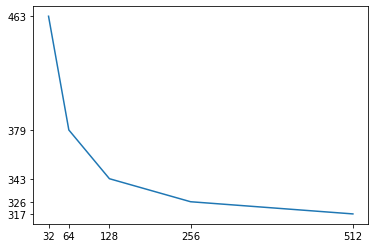

In [19]:
plt.plot(x, y)
plt.xticks(x)
plt.yticks(y)
plt.show()

In [12]:
logx = np.log(x)
logy = np.log(y)
coeffs = np.polyfit(logx, logy, deg=1)
poly = np.poly1d(coeffs)

In [13]:
yfit = lambda x: np.exp(poly(np.log(x)))

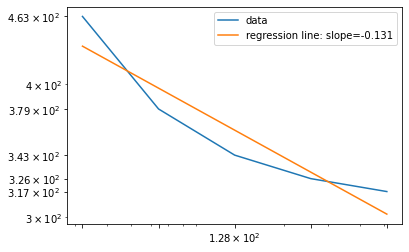

In [27]:
plt.loglog(x, y)
plt.loglog(x, yfit(x))
plt.xticks(x)
plt.yticks(y)
plt.legend(["data", f"regression line: slope={coeffs[0]:.3f}"])